In [1]:
import warnings

import dandelion as ddl
import pandas as pd
import scanpy as sc

from numba.core.errors import (
    NumbaDeprecationWarning,
)  # silence numba deprecation warning
from pathlib import Path

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)
sc.settings.verbosity = 3

sc.logging.print_header()
ddl.logging.print_header()

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 pynndescent==0.5.10
dandelion==0.3.4.dev12 pandas==1.5.3 numpy==1.24.4 matplotlib==3.7.1 networkx==3.1 scipy==1.11.2


In [2]:
DATA_PATH = Path("..") / "data"
LOCAL_PATH = DATA_PATH / "local"

In [3]:
adata = sc.read_h5ad(DATA_PATH / "adata_bcr.h5ad")
# reconstruct to umap
if "log1p" in adata.uns:
    adata.uns.pop("log1p")
adata

AnnData object with n_obs × n_vars = 53648 × 32285
    obs: 'sample_id_actual', 'culture_id', 'Treatment', 'Timepoint', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch', 'leiden', 'celltype', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call

In [4]:
adata.obs["Treatment_Timepoint"] = (
    adata.obs.Treatment.astype(str) + "_" + adata.obs.Timepoint.astype(str)
)

In [5]:
# # subset to the largest clone
adatas = {}
for x in list(set(adata.obs["sample_id_actual"])):
    print(x)
    adatas[x] = adata[
        (adata.obs.clone_id_size >= 3) & (adata.obs["sample_id_actual"] == x)
    ].copy()
    print(adatas[x])

BC2-CD40-120h
AnnData object with n_obs × n_vars = 1123 × 32285
    obs: 'sample_id_actual', 'culture_id', 'Treatment', 'Timepoint', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch', 'leiden', 'celltype', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_m

In [6]:
import rbo

import numpy as np

from tqdm import tqdm
from itertools import product
from scipy.stats import kendalltau, spearmanr


def initialise_ranking_matrix(adata):
    # Initialize an empty matrix to store the rankings
    rankings_matrix = np.zeros(adata.X.shape, dtype=int)

    # Loop through each row of the CSR matrix
    for i in range(adata.X.shape[0]):
        # Get the indices that would sort the current row
        sorted_indices = np.argsort(adata.X.getrow(i).toarray())[0, ::-1]

        # Store the rankings in the rankings matrix
        rankings_matrix[i, sorted_indices] = np.arange(1, adata.X.shape[1] + 1)
    return rankings_matrix


def clone_gene_ranking_rbo(adata):
    rankings_matrix = initialise_ranking_matrix(adata)
    results = dict()
    for i, j in product(range(rankings_matrix.shape[0]), repeat=2):
        if i != j:
            results[(i, j)] = rbo.RankingSimilarity(
                rankings_matrix[i], rankings_matrix[j]
            ).rbo()
    return results


def clone_gene_ranking_kendalltau(adata):
    rankings_matrix = initialise_ranking_matrix(adata)
    results = dict()
    for i, j in product(range(rankings_matrix.shape[0]), repeat=2):
        if i != j:
            results[(i, j)] = kendalltau(
                rankings_matrix[i], rankings_matrix[j]
            ).statistic
    return results


def clone_gene_ranking_spearman(adata):
    rankings_matrix = initialise_ranking_matrix(adata)
    results = dict()
    for i, j in product(range(rankings_matrix.shape[0]), repeat=2):
        if i != j:
            results[(i, j)] = spearmanr(
                rankings_matrix[i], rankings_matrix[j]
            ).statistic
    return results

In [7]:
from collections import defaultdict

kendalltau_res = defaultdict(dict)
rbo_res = defaultdict(dict)
spearman_res = defaultdict(dict)
for x in adatas:
    for y in tqdm(list(set(adatas[x].obs.clone_id))):
        tmp = adatas[x][adatas[x].obs.clone_id == y].copy()
        kendalltau_res[x][y] = clone_gene_ranking_kendalltau(tmp)
        spearman_res[x][y] = clone_gene_ranking_spearman(tmp)
        rbo_res[x][y] = clone_gene_ranking_rbo(tmp)

100%|██████████| 408/408 [00:28<00:00, 14.21it/s]


In [8]:
kendalltau_res2 = defaultdict(dict)
rbo_res2 = defaultdict(dict)
spearman_res2 = defaultdict(dict)

In [9]:
for x in kendalltau_res:
    for y in kendalltau_res[x]:
        avg = np.mean(list(kendalltau_res[x][y].values()))
        if pd.notnull(avg):
            kendalltau_res2[x][y] = avg

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide


In [10]:
for x in rbo_res:
    for y in rbo_res[x]:
        avg = np.mean(list(rbo_res[x][y].values()))
        if pd.notnull(avg):
            rbo_res2[x][y] = avg

In [11]:
for x in spearman_res:
    for y in spearman_res[x]:
        avg = np.mean(list(spearman_res[x][y].values()))
        if pd.notnull(avg):
            spearman_res2[x][y] = avg

In [99]:
def prep_result(result, group_name, statistic_name):
    dats = []
    for x in result:
        keys = pd.DataFrame(list(result[x].keys()), columns=["clone_id"])
        values = pd.DataFrame(list(result[x].values()), columns=[statistic_name])
        tmp = pd.concat([keys, values], axis=1)
        tmp[group_name] = x
        dats.append(tmp)
    df = pd.concat(dats)
    return df

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
kt_df = prep_result(kendalltau_res2, "sample_id_actual", "Kendall Tau")
s_df = prep_result(spearman_res2, "sample_id_actual", "Spearman R")
rbo_df = prep_result(rbo_res2, "sample_id_actual", "RBO")

In [102]:
kt_df

,clone_id,Kendall Tau,sample_id_actual
0,B_159_8_6_326_2_1,0.702390,BC2-CD40-120h
1,B_74_7_3_413_2_1,0.720405,BC2-CD40-120h
2,B_266_10_2_173_1_4,0.641264,BC2-CD40-120h
3,B_87_5_2_262_2_3,0.762005,BC2-CD40-120h
4,B_230_5_3_400_2_1,0.670230,BC2-CD40-120h
...,...,...,...
186,B_324_5_2_316_3_1,0.800228,BC2-CD40-72h
187,B_342_5_1_149_1_1,0.670906,BC2-CD40-72h
188,B_11_5_1_324_1_1,0.743839,BC2-CD40-72h
189,B_257_4_3_256_3_1|B_257_4_3_385_2_1,0.788856,BC2-CD40-72h


In [103]:
kt_df.sample_id_actual = kt_df.sample_id_actual.astype("category")
kt_df.sample_id_actual = kt_df.sample_id_actual.cat.reorder_categories(
    [
        "BC1-CpG",
        "BC2-CpG",
        "BC1-CD40-72h",
        "BC2-CD40-72h",
        "BC1-CD40-120h",
        "BC2-CD40-120h",
    ]
)

s_df.sample_id_actual = s_df.sample_id_actual.astype("category")
s_df.sample_id_actual = s_df.sample_id_actual.cat.reorder_categories(
    [
        "BC1-CpG",
        "BC2-CpG",
        "BC1-CD40-72h",
        "BC2-CD40-72h",
        "BC1-CD40-120h",
        "BC2-CD40-120h",
    ]
)

rbo_df.sample_id_actual = rbo_df.sample_id_actual.astype("category")
rbo_df.sample_id_actual = rbo_df.sample_id_actual.cat.reorder_categories(
    [
        "BC1-CpG",
        "BC2-CpG",
        "BC1-CD40-72h",
        "BC2-CD40-72h",
        "BC1-CD40-120h",
        "BC2-CD40-120h",
    ]
)

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 40.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


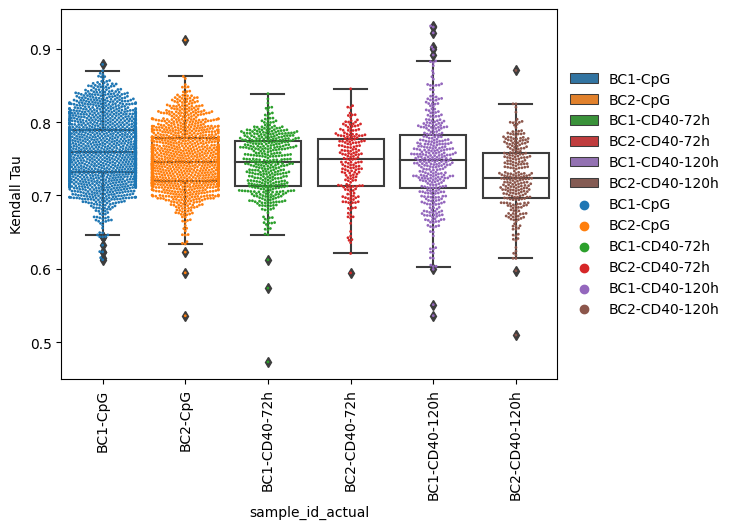

In [104]:
sns.boxplot(
    kt_df,
    x="sample_id_actual",
    y="Kendall Tau",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    kt_df,
    x="sample_id_actual",
    y="Kendall Tau",
    hue="sample_id_actual",
    size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 43.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 31.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


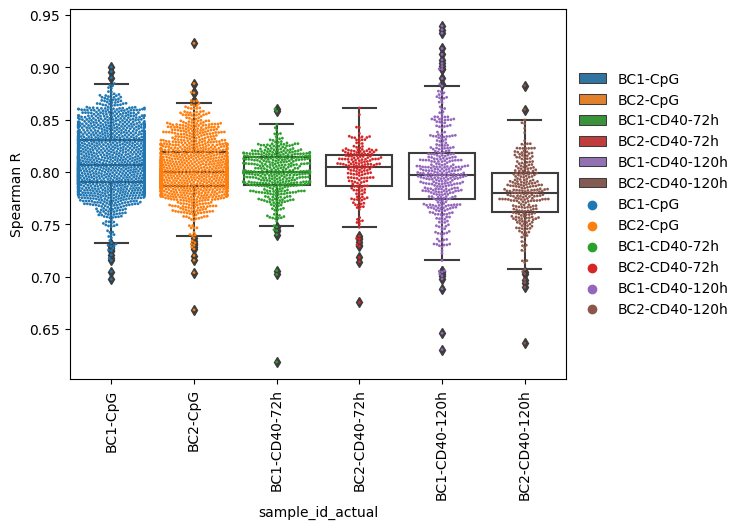

In [105]:
sns.boxplot(
    s_df,
    x="sample_id_actual",
    y="Spearman R",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    s_df,
    x="sample_id_actual",
    y="Spearman R",
    hue="sample_id_actual",
    size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


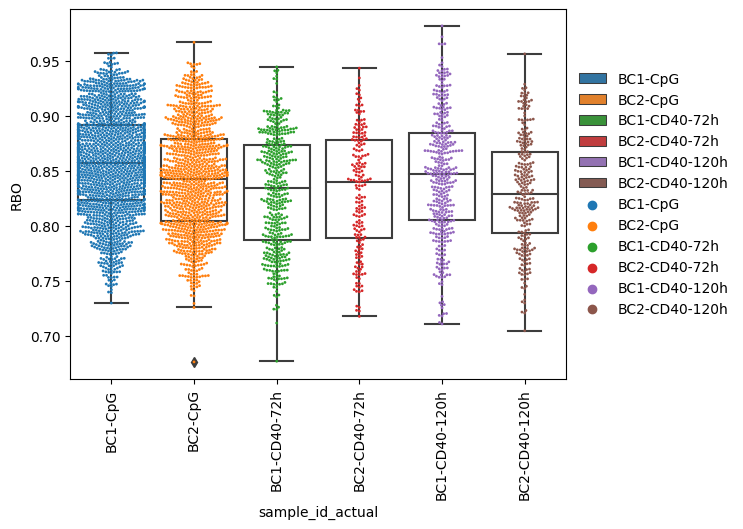

In [106]:
sns.boxplot(
    rbo_df,
    x="sample_id_actual",
    y="RBO",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    rbo_df,
    x="sample_id_actual",
    y="RBO",
    hue="sample_id_actual",
    size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

In [107]:
s_df.to_csv("spearman.csv")
rbo_df.to_csv("rbo.csv")
kt_df.to_csv("kendalltau.csv")

In [108]:
# tabulate clone size fractions
rbo_df

,clone_id,RBO,sample_id_actual
0,B_159_8_6_326_2_1,0.775298,BC2-CD40-120h
1,B_74_7_3_413_2_1,0.828197,BC2-CD40-120h
2,B_266_10_2_173_1_4,0.761048,BC2-CD40-120h
3,B_87_5_2_262_2_3,0.862795,BC2-CD40-120h
4,B_230_5_3_400_2_1,0.779562,BC2-CD40-120h
...,...,...,...
186,B_324_5_2_316_3_1,0.892114,BC2-CD40-72h
187,B_342_5_1_149_1_1,0.767148,BC2-CD40-72h
188,B_11_5_1_324_1_1,0.851653,BC2-CD40-72h
189,B_257_4_3_256_3_1|B_257_4_3_385_2_1,0.880100,BC2-CD40-72h


In [109]:
clone_id_sizes = adata.obs.clone_id.value_counts()
clone_id_sizes

No_contig            24467
B_342_2_1_99_2_3        22
B_26_3_3_21_2_1         21
B_2_6_8_275_2_2         17
B_320_3_2_29_2_1        16
                     ...  
B_209_2_1_368_2_3        1
B_86_13_2_27_1_1         1
B_208_9_1_410_2_3        1
B_208_8_4_146_2_3        1
B_172_4_1_102_1_1        1
Name: clone_id, Length: 13870, dtype: int64

In [138]:
share = pd.crosstab(adata.obs.clone_id, adata.obs.sample_id_actual)
share.drop("No_contig", axis=0, inplace=True)
share.drop(["BC1-CpG", "BC2-CpG"], axis=1, inplace=True)
share[share > 0] = 1
share

sample_id_actual,BC1-CD40-72h,BC1-CD40-120h,BC2-CD40-72h,BC2-CD40-120h
clone_id,,,,
B_1_1_1_198_1_1,0,0,0,0
B_1_2_1_396_2_1,0,0,0,0
B_1_2_2_87_1_1,0,0,1,0
B_1_2_3_64_2_1,1,0,0,0
B_1_2_3_307_2_11|B_1_2_3_64_2_1,0,1,0,0
...,...,...,...,...
B_361_3_1_158_3_1|B_361_3_1_171_1_3|B_361_3_1_50_2_1,0,1,0,0
B_361_3_1_224_3_1|B_361_3_1_287_1_1,0,1,0,0
B_361_3_1_287_1_1,0,1,0,0


In [139]:
xx = share.apply(lambda r: r.sum(), axis=1) > 1
xx

clone_id
B_1_1_1_198_1_1                                         False
B_1_2_1_396_2_1                                         False
B_1_2_2_87_1_1                                          False
B_1_2_3_64_2_1                                          False
B_1_2_3_307_2_11|B_1_2_3_64_2_1                         False
                                                        ...  
B_361_3_1_158_3_1|B_361_3_1_171_1_3|B_361_3_1_50_2_1    False
B_361_3_1_224_3_1|B_361_3_1_287_1_1                     False
B_361_3_1_287_1_1                                       False
B_361_3_1_287_1_1|B_361_3_1_47_2_4|B_361_3_1_50_2_1     False
B_361_4_1_6_2_1                                         False
Length: 13869, dtype: bool

In [140]:
shared_clones = list(xx[xx].index)
shared_clones

['B_1_3_1_342_2_3',
 'B_1_3_4_316_3_1',
 'B_1_4_1_66_2_5',
 'B_1_4_2_188_2_1',
 'B_1_6_3_15_3_1',
 'B_2_2_1_218_1_1',
 'B_2_2_2_344_2_4',
 'B_2_5_10_307_2_11',
 'B_2_5_16_331_2_1',
 'B_2_6_3_324_1_1',
 'B_2_6_19_362_1_4',
 'B_2_7_1_404_2_1',
 'B_2_7_12_364_1_1',
 'B_2_7_21_139_3_1',
 'B_2_7_30_147_2_3',
 'B_2_8_14_235_1_1',
 'B_2_8_16_76_1_1',
 'B_2_8_24_74_1_1',
 'B_2_8_38_140_2_1',
 'B_2_9_2_83_2_1',
 'B_2_9_5_33_2_1',
 'B_2_9_14_385_2_1',
 'B_2_9_23_307_2_6',
 'B_2_10_5_358_1_1',
 'B_2_10_8_102_2_1',
 'B_2_11_6_194_2_3|B_2_11_6_307_2_11',
 'B_2_14_1_410_2_3',
 'B_3_2_1_162_1_5',
 'B_3_3_3_261_1_1',
 'B_3_12_1_22_2_1',
 'B_4_1_1_414_1_1',
 'B_5_4_2_222_1_1',
 'B_5_5_1_307_2_11',
 'B_5_5_3_96_3_3',
 'B_5_5_8_179_1_1',
 'B_5_6_2_13_1_2',
 'B_5_9_1_177_2_2|B_5_9_1_307_2_11',
 'B_5_9_4_157_2_3',
 'B_8_5_2_140_2_1',
 'B_8_7_1_170_1_1',
 'B_8_7_4_229_2_3',
 'B_10_1_1_228_2_1',
 'B_10_6_5_204_3_1',
 'B_10_9_2_204_3_1',
 'B_11_7_3_211_2_1',
 'B_11_9_1_33_2_1',
 'B_11_10_2_279_2_1',
 'B_12_3_

In [141]:
kt_df.reset_index(drop=True, inplace=True)
s_df.reset_index(drop=True, inplace=True)
rbo_df.reset_index(drop=True, inplace=True)

In [142]:
kt_df["shared"] = None
s_df["shared"] = None
rbo_df["shared"] = None

In [143]:
for i in kt_df.index:
    if kt_df.at[i, "clone_id"] in shared_clones:
        kt_df.at[i, "shared"] = True

for i in s_df.index:
    if s_df.at[i, "clone_id"] in shared_clones:
        s_df.at[i, "shared"] = True

for i in rbo_df.index:
    if rbo_df.at[i, "clone_id"] in shared_clones:
        rbo_df.at[i, "shared"] = True

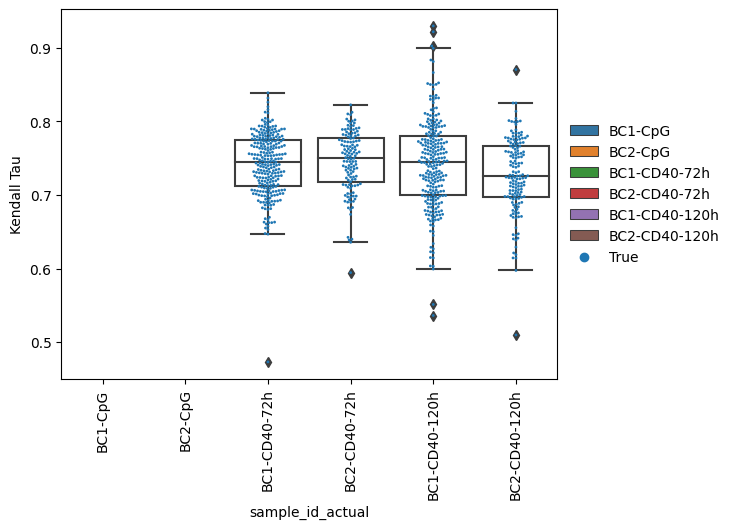

In [144]:
sns.boxplot(
    kt_df[kt_df.shared == True],
    x="sample_id_actual",
    y="Kendall Tau",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    kt_df[kt_df.shared == True],
    x="sample_id_actual",
    y="Kendall Tau",
    hue="shared",
    size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

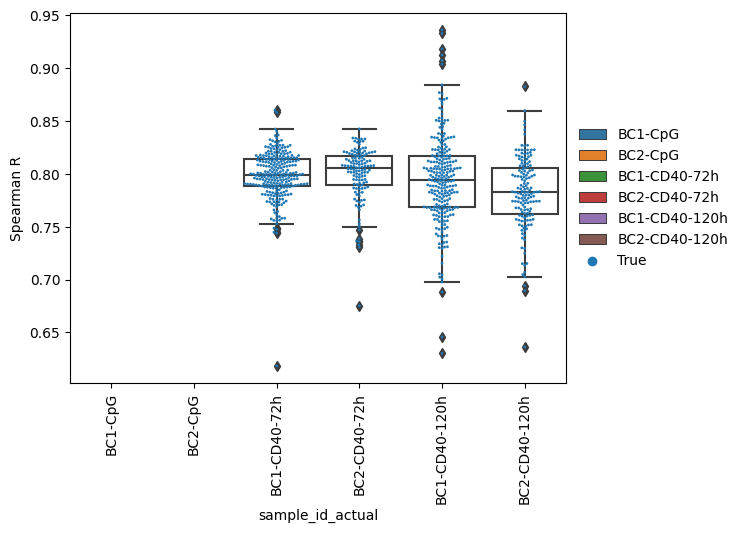

In [145]:
sns.boxplot(
    s_df[s_df.shared == True],
    x="sample_id_actual",
    y="Spearman R",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    s_df[s_df.shared == True],
    x="sample_id_actual",
    y="Spearman R",
    hue="shared",
    size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

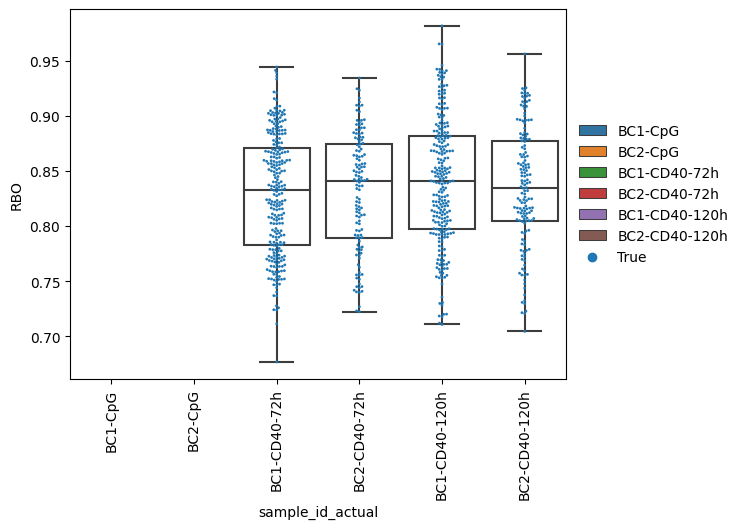

In [146]:
sns.boxplot(
    rbo_df[rbo_df.shared == True],
    x="sample_id_actual",
    y="RBO",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    rbo_df[rbo_df.shared == True],
    x="sample_id_actual",
    y="RBO",
    hue="shared",
    size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

In [147]:
share = pd.crosstab(adata.obs.clone_id, adata.obs.sample_id_actual)
share.drop("No_contig", axis=0, inplace=True)
share.drop(["BC1-CpG", "BC2-CpG"], axis=1, inplace=True)
share

sample_id_actual,BC1-CD40-72h,BC1-CD40-120h,BC2-CD40-72h,BC2-CD40-120h
clone_id,,,,
B_1_1_1_198_1_1,0,0,0,0
B_1_2_1_396_2_1,0,0,0,0
B_1_2_2_87_1_1,0,0,1,0
B_1_2_3_64_2_1,1,0,0,0
B_1_2_3_307_2_11|B_1_2_3_64_2_1,0,1,0,0
...,...,...,...,...
B_361_3_1_158_3_1|B_361_3_1_171_1_3|B_361_3_1_50_2_1,0,1,0,0
B_361_3_1_224_3_1|B_361_3_1_287_1_1,0,1,0,0
B_361_3_1_287_1_1,0,4,0,0


In [149]:
share["BC1_delta"] = (share["BC1-CD40-120h"] - share["BC1-CD40-72h"]) / share[
    "BC1-CD40-72h"
]
share["BC2_delta"] = (share["BC2-CD40-120h"] - share["BC2-CD40-72h"]) / share[
    "BC2-CD40-72h"
]
share

sample_id_actual,BC1-CD40-72h,BC1-CD40-120h,BC2-CD40-72h,BC2-CD40-120h,BC1_delta,BC2_delta
clone_id,,,,,,
B_1_1_1_198_1_1,0,0,0,0,NaN,NaN
B_1_2_1_396_2_1,0,0,0,0,NaN,NaN
B_1_2_2_87_1_1,0,0,1,0,NaN,-1.0
B_1_2_3_64_2_1,1,0,0,0,-1.0,NaN
B_1_2_3_307_2_11|B_1_2_3_64_2_1,0,1,0,0,inf,NaN
...,...,...,...,...,...,...
B_361_3_1_158_3_1|B_361_3_1_171_1_3|B_361_3_1_50_2_1,0,1,0,0,inf,NaN
B_361_3_1_224_3_1|B_361_3_1_287_1_1,0,1,0,0,inf,NaN
B_361_3_1_287_1_1,0,4,0,0,inf,NaN


In [155]:
import math

In [192]:
up = share[
    ((share["BC1_delta"] > 1) & (share["BC1_delta"] < math.inf))
    # | ((share["BC2_delta"] > 1) & (share["BC2_delta"] < math.inf))
]
up

sample_id_actual,BC1-CD40-72h,BC1-CD40-120h,BC2-CD40-72h,BC2-CD40-120h,BC1_delta,BC2_delta
clone_id,,,,,,
B_18_7_5_378_1_3,2,8,0,0,3.0,NaN
B_18_7_8_363_1_3,1,3,0,0,2.0,NaN
B_20_6_1_226_3_1,1,5,0,0,4.0,NaN
B_30_6_1_344_2_4,1,3,0,0,2.0,NaN
B_32_7_12_356_1_1,1,4,0,0,3.0,NaN
...,...,...,...,...,...,...
B_342_2_1_99_2_3,4,18,0,0,3.5,NaN
B_342_5_14_96_4_1,1,3,0,0,2.0,NaN
B_346_8_1_18_2_5,2,6,0,0,2.0,NaN


In [193]:
down = share[
    ((share["BC1_delta"] < -1) & (share["BC1_delta"] > -math.inf))
    # | ((share["BC2_delta"] < -1) & (share["BC2_delta"] > -math.inf))
]
down

sample_id_actual,BC1-CD40-72h,BC1-CD40-120h,BC2-CD40-72h,BC2-CD40-120h,BC1_delta,BC2_delta
clone_id,,,,,,


In [194]:
up

sample_id_actual,BC1-CD40-72h,BC1-CD40-120h,BC2-CD40-72h,BC2-CD40-120h,BC1_delta,BC2_delta
clone_id,,,,,,
B_18_7_5_378_1_3,2,8,0,0,3.0,NaN
B_18_7_8_363_1_3,1,3,0,0,2.0,NaN
B_20_6_1_226_3_1,1,5,0,0,4.0,NaN
B_30_6_1_344_2_4,1,3,0,0,2.0,NaN
B_32_7_12_356_1_1,1,4,0,0,3.0,NaN
...,...,...,...,...,...,...
B_342_2_1_99_2_3,4,18,0,0,3.5,NaN
B_342_5_14_96_4_1,1,3,0,0,2.0,NaN
B_346_8_1_18_2_5,2,6,0,0,2.0,NaN


In [195]:
kt_df["up"] = None
s_df["up"] = None
rbo_df["up"] = None

In [196]:
for i in kt_df.index:
    if kt_df.at[i, "clone_id"] in up.index:
        kt_df.at[i, "up"] = True

for i in s_df.index:
    if s_df.at[i, "clone_id"] in up.index:
        s_df.at[i, "up"] = True

for i in rbo_df.index:
    if rbo_df.at[i, "clone_id"] in up.index:
        rbo_df.at[i, "up"] = True

In [212]:
kt_df.clone_id.value_counts() > 1

B_209_8_3_98_2_1                        True
B_204_8_5_96_4_1                        True
B_209_8_5_232_2_1                       True
B_324_5_2_316_3_1                       True
B_257_4_3_256_3_1|B_257_4_3_385_2_1     True
                                       ...  
B_336_2_4_87_2_1                       False
B_47_7_4_140_4_1                       False
B_23_4_6_374_2_4                       False
B_269_4_3_98_2_1                       False
B_11_5_1_324_1_1                       False
Name: clone_id, Length: 3859, dtype: bool

In [222]:
more_than_one = kt_df.clone_id.value_counts() > 1
more_than_one = list(more_than_one[more_than_one].index)
more_than_one

['B_209_8_3_98_2_1',
 'B_204_8_5_96_4_1',
 'B_209_8_5_232_2_1',
 'B_324_5_2_316_3_1',
 'B_257_4_3_256_3_1|B_257_4_3_385_2_1',
 'B_271_3_2_215_1_1',
 'B_353_8_7_356_1_1',
 'B_239_4_6_204_3_1',
 'B_144_9_2_404_2_1',
 'B_292_6_4_34_2_1|B_292_6_4_396_2_1',
 'B_54_6_3_321_2_3',
 'B_154_6_5_157_2_3',
 'B_297_4_6_141_2_1',
 'B_214_8_3_188_2_1',
 'B_257_5_5_173_1_4',
 'B_102_9_1_66_3_1',
 'B_229_11_3_331_2_1',
 'B_204_6_5_344_2_4',
 'B_97_11_2_96_3_3',
 'B_107_10_4_279_1_3|B_107_10_4_282_1_1',
 'B_197_8_14_278_2_1',
 'B_137_7_5_268_2_4',
 'B_304_5_7_81_1_1',
 'B_77_6_4_6_2_1',
 'B_270_4_1_344_2_4',
 'B_183_4_1_116_1_3',
 'B_72_5_2_162_1_5|B_72_5_2_307_2_11',
 'B_353_3_3_77_1_1',
 'B_246_4_4_234_2_4',
 'B_159_8_18_203_3_5|B_159_8_18_322_1_1',
 'B_238_7_5_161_1_1',
 'B_93_6_11_24_1_1',
 'B_237_7_6_161_1_1',
 'B_208_5_3_272_2_3',
 'B_353_10_3_342_2_3|B_353_10_3_344_3_1',
 'B_274_6_13_173_1_4',
 'B_183_4_7_317_2_2',
 'B_89_1_1_307_2_11',
 'B_271_7_9_162_1_5',
 'B_250_6_11_404_2_1',
 'B_23_4_2_312_

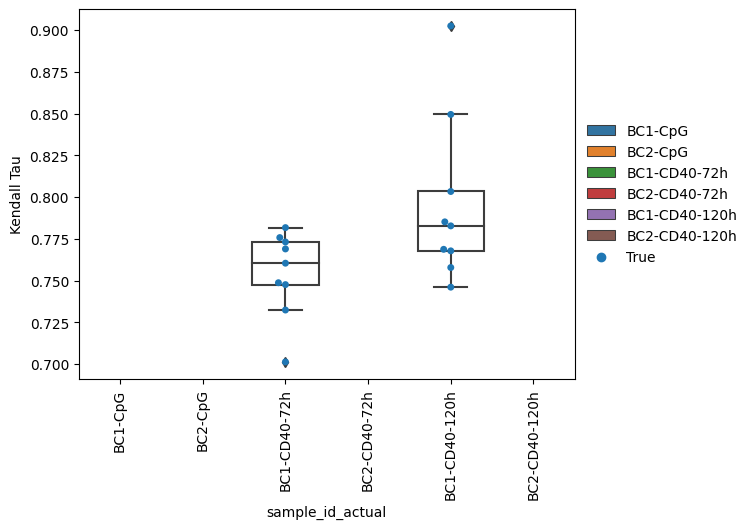

In [225]:
sns.boxplot(
    kt_df[(kt_df.up == True) & (kt_df.clone_id.isin(more_than_one))],
    x="sample_id_actual",
    y="Kendall Tau",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    kt_df[(kt_df.up == True) & (kt_df.clone_id.isin(more_than_one))],
    x="sample_id_actual",
    y="Kendall Tau",
    hue="up",
    # size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

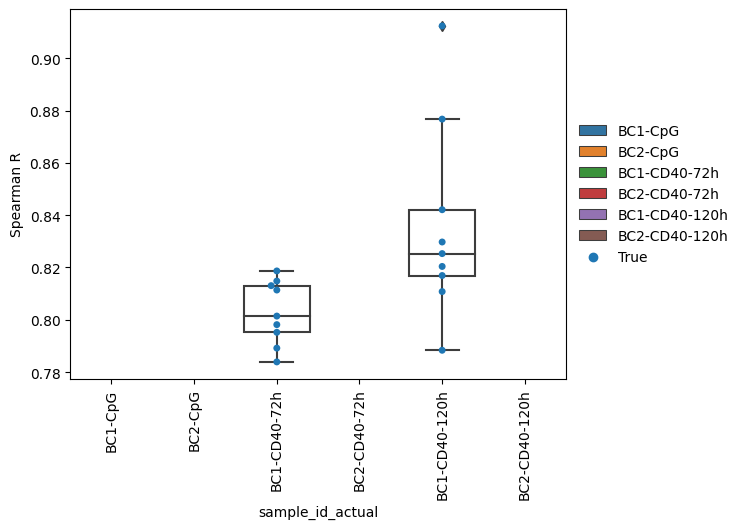

In [226]:
sns.boxplot(
    s_df[(s_df.up == True) & (s_df.clone_id.isin(more_than_one))],
    x="sample_id_actual",
    y="Spearman R",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    s_df[(s_df.up == True) & (s_df.clone_id.isin(more_than_one))],
    x="sample_id_actual",
    y="Spearman R",
    hue="up",
    # size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

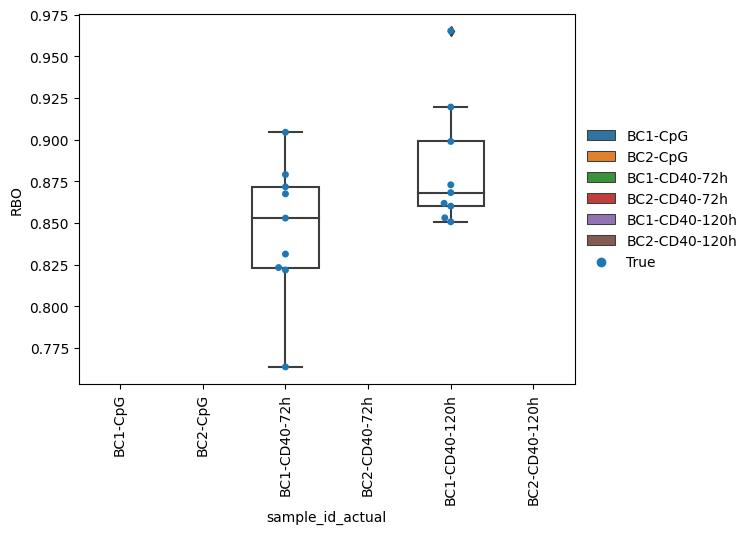

In [227]:
sns.boxplot(
    rbo_df[(rbo_df.up == True) & (rbo_df.clone_id.isin(more_than_one))],
    x="sample_id_actual",
    y="RBO",
    hue="sample_id_actual",
    boxprops={"facecolor": "None"},
    dodge=False,
)
sns.swarmplot(
    rbo_df[(rbo_df.up == True) & (rbo_df.clone_id.isin(more_than_one))],
    x="sample_id_actual",
    y="RBO",
    hue="up",
    # size=2,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

In [ ]:
# tabulate clone size fractions
rbo_df

,clone_id,RBO,sample_id_actual
0,B_159_8_6_326_2_1,0.775298,BC2-CD40-120h
1,B_74_7_3_413_2_1,0.828197,BC2-CD40-120h
2,B_266_10_2_173_1_4,0.761048,BC2-CD40-120h
3,B_87_5_2_262_2_3,0.862795,BC2-CD40-120h
4,B_230_5_3_400_2_1,0.779562,BC2-CD40-120h
...,...,...,...
186,B_324_5_2_316_3_1,0.892114,BC2-CD40-72h
187,B_342_5_1_149_1_1,0.767148,BC2-CD40-72h
188,B_11_5_1_324_1_1,0.851653,BC2-CD40-72h
189,B_257_4_3_256_3_1|B_257_4_3_385_2_1,0.880100,BC2-CD40-72h


In [41]:
cell_frac = defaultdict(dict)
for x in rbo_res2:
    clone_ids = list(rbo_res2[x].keys())
    for c in clone_ids:
        cell_frac[x][c] = clone_id_sizes.loc[c]

In [48]:
tmps = []
for x in cell_frac:
    tmp = pd.DataFrame(list(cell_frac[x].values()))
    tmp["sample_id_actual"] = x
    tmps.append(tmp)
final = pd.concat(tmps)

In [50]:
final.shape

(4011, 2)

In [53]:
final

,0,sample_id_actual
0,2,BC2-CD40-120h
1,2,BC2-CD40-120h
2,4,BC2-CD40-120h
3,3,BC2-CD40-120h
4,2,BC2-CD40-120h
...,...,...
186,4,BC2-CD40-72h
187,3,BC2-CD40-72h
188,2,BC2-CD40-72h
189,4,BC2-CD40-72h


In [52]:
rbo_df.shape

(4011, 2)

In [54]:
rbo_df

,RBO,sample_id_actual
0,0.775298,BC2-CD40-120h
1,0.828197,BC2-CD40-120h
2,0.761048,BC2-CD40-120h
3,0.862795,BC2-CD40-120h
4,0.779562,BC2-CD40-120h
...,...,...
186,0.892114,BC2-CD40-72h
187,0.767148,BC2-CD40-72h
188,0.851653,BC2-CD40-72h
189,0.880100,BC2-CD40-72h


<Axes: xlabel='0', ylabel='RBO'>

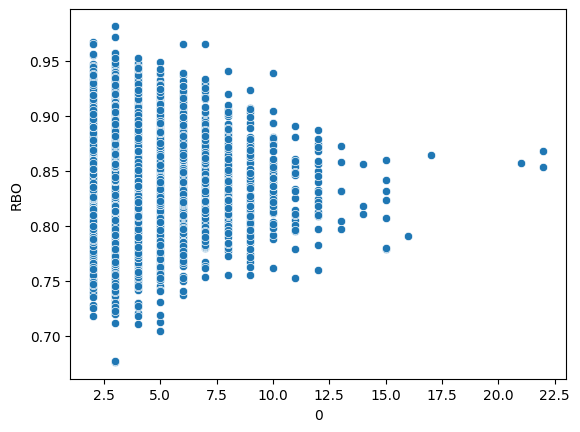

In [57]:
sns.scatterplot(x=final[0], y=rbo_df["RBO"])